## Analyze all profile data and interpolate it onto a grid

This notebook takes all the VMP profiler data (which Ivan called the underwater surveys) and plots it up.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.io
import glob

### Load in all the profile data!

#### Sept Cruise Profiles

In [3]:
names = ['transect_1', 'transect_2', 'transect_5', 'transect_6', 'transect_9']
li = []
for i, fn in enumerate(['data/VMP/Cruise2/VMPsurvey_052.mat', 'data/VMP/Cruise2/VMPsurvey_053.mat', 'data/VMP/Cruise2/VMPsurvey_056.mat',
                       'data/VMP/Cruise2/VMPsurvey_057.mat', 'data/VMP/Cruise2/VMPsurvey_059.mat']):
    mat = scipy.io.loadmat(fn)
    for item in list(mat.keys()):
        if item not in ['__header__', '__version__', '__globals__']:
            df = pd.DataFrame(data=mat[item], columns=['time', 'depth (dBars)', 'temp (C)','salinity (PSU)', 'potential density (kg/m^3 -1000)', 
                                                    'chla (ppb)', 'turbidity (FTU)', 'turb kinetic energy 1 (W/kg)', 'turb kinetic energy 2 (W/kg)'])
            df['transect'] = names[i]
            df['profile_num'] = int(item.split('profile')[-1])
            li.append(df)

profiles = pd.concat(li, axis=0, ignore_index=True)
profiles['dt'] = pd.to_datetime('2021-1-1') + pd.to_timedelta(profiles.time, unit='D') - pd.Timedelta(days=1)
profiles = profiles.set_index('dt')
profiles = profiles.sort_index(ascending=True)
profiles['datetime'] = pd.to_datetime('2021-1-1') + pd.to_timedelta(profiles.time, unit='D') - pd.Timedelta(days=1)

In [4]:
profiles.head(1)

time  depth (dBars)   temp (C)  \
dt                                                                    
2021-09-05 15:57:05.065257600  248.664642      -1.715667  28.753652   

                               salinity (PSU)  \
dt                                              
2021-09-05 15:57:05.065257600       35.990978   

                               potential density (kg/m^3 -1000)  chla (ppb)  \
dt                                                                            
2021-09-05 15:57:05.065257600                          22.89321   -0.215259   

                               turbidity (FTU)  turb kinetic energy 1 (W/kg)  \
dt                                                                             
2021-09-05 15:57:05.065257600         1.044783                      0.013345   

                               turb kinetic energy 2 (W/kg)    transect  \
dt                                                                        
2021-09-05 15:57:05.065257600                      0.003765  transect_1   

                               profile_num                      datetime  
dt                                                                        
2021-09-05 15:57:05.065257600            1 2021-09-05 15:57:05.065257600

In [5]:
plt.rcParams.update({'font.size': 14})

Calculate Mixed Layer Depth for Alex's calculations

In [6]:
# a change of 0.1 kg/m3 compared to 5m
mld_list = []
dt_list = []
surface_density_list = []
transect_list = []
for i in np.unique(profiles.transect):
    df_subset = profiles[profiles.transect == i]
    for j in np.unique(df_subset.profile_num): # this is getting each profile from this transect
        surface_density = df_subset[(df_subset.profile_num == j) & (df_subset['depth (dBars)'] > -7) & (df_subset['depth (dBars)'] < -3)]['potential density (kg/m^3 -1000)'].mean()
        mld = df_subset[(df_subset.profile_num == j) & (df_subset['potential density (kg/m^3 -1000)'] > surface_density+.1)]['depth (dBars)']
        surface_density_list.append(surface_density)
        transect_list.append(int(i[-1]))
        dt_list.append(df_subset[(df_subset.profile_num == j)].head(1)['datetime'].values[0])
        
        mld_list.append(mld.head(1).values)

In [7]:
len(dt_list), len(mld_list)

(121, 121)

In [8]:
mld_clean = []
dt_clean  = []
surface_density_clean = []
transect_clean = []
for i in range(len(mld_list)):
    if mld_list[i].size>0:
        mld_clean.append(mld_list[i][0])
        dt_clean.append(dt_list[i])
        surface_density_clean.append(surface_density_list[i])
        transect_clean.append(transect_list[i])
        

In [9]:
mld_clean = np.array(mld_clean)

In [10]:
mld_df = pd.DataFrame(np.array([dt_clean, mld_clean]).T, columns=['datetime (UTC)', 'MLD (m)'])

In [11]:
# mld_df.to_csv('mld_csv_sw0921_pcg.csv', index=False)

Visualize the mixed layer depth data

The comments/titles on these are for the Sept cruise

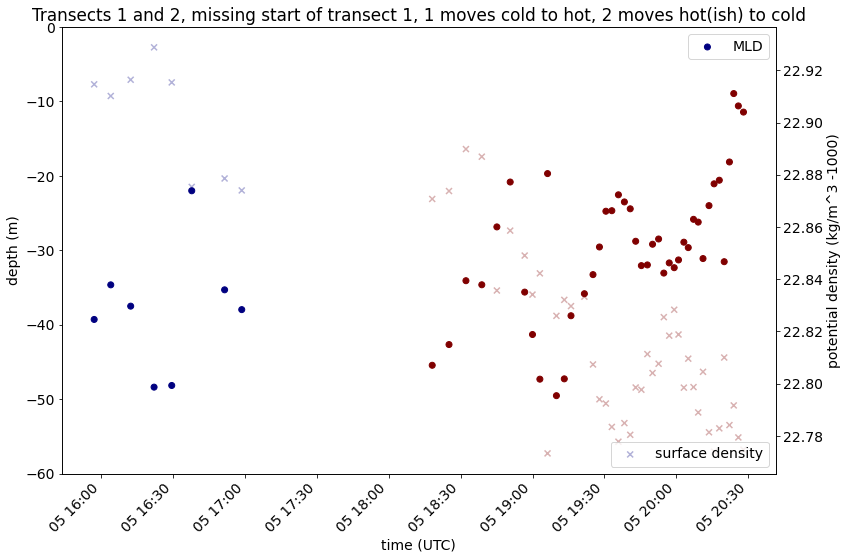

In [12]:
index_start = 0
index_end = 51
fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(dt_clean[index_start:index_end], mld_clean[index_start:index_end], cmap='jet', c = transect_clean[index_start:index_end], label='MLD')
ax2 = ax.twinx()
ax2.scatter(dt_clean[index_start:index_end], surface_density_clean[index_start:index_end], cmap='jet', c = transect_clean[index_start:index_end], marker='x', alpha=0.3, label='surface density')

fig.autofmt_xdate(rotation=45)
ax.set_ylim(-60, 0)
ax.set_title('Transects 1 and 2, missing start of transect 1, 1 moves cold to hot, 2 moves hot(ish) to cold')

ax.set_ylabel('depth (m)')
ax2.set_ylabel('potential density (kg/m^3 -1000)')
ax.set_xlabel('time (UTC)')
ax.legend()
ax2.legend(loc='lower right')
fig.tight_layout()
# fig.savefig('sept5_mld.png')

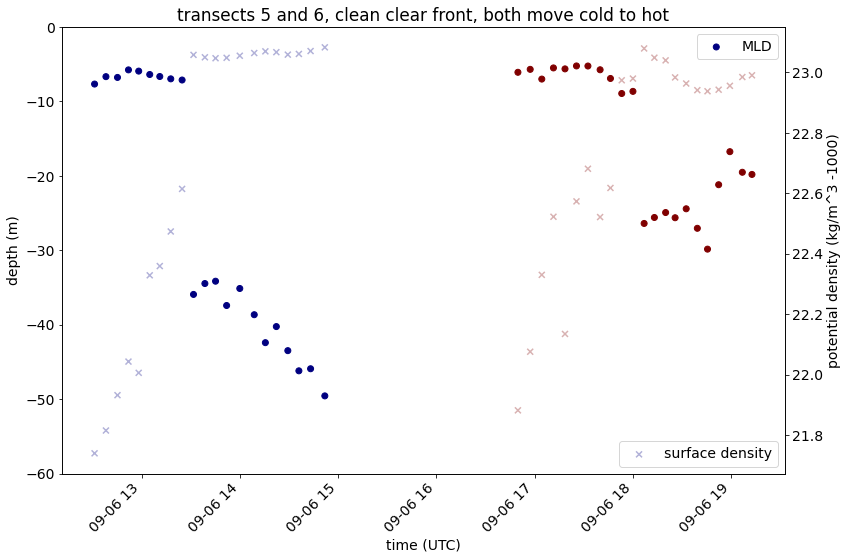

In [13]:
index_start = 51
index_end = 94
fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(dt_clean[index_start:index_end], mld_clean[index_start:index_end], c = transect_clean[index_start:index_end], cmap='jet', label='MLD')
ax2 = ax.twinx()
ax2.scatter(dt_clean[index_start:index_end], surface_density_clean[index_start:index_end], c = transect_clean[index_start:index_end], cmap='jet', marker='x', alpha=0.3, label='surface density')

fig.autofmt_xdate(rotation=45)
ax.set_ylim(-60, 0)
ax.set_title('transects 5 and 6, clean clear front, both move cold to hot')

ax.set_ylabel('depth (m)')
ax2.set_ylabel('potential density (kg/m^3 -1000)')
ax.set_xlabel('time (UTC)')
ax.legend()
ax2.legend(loc='lower right')
fig.tight_layout()
# fig.savefig('sept6_mld.png')

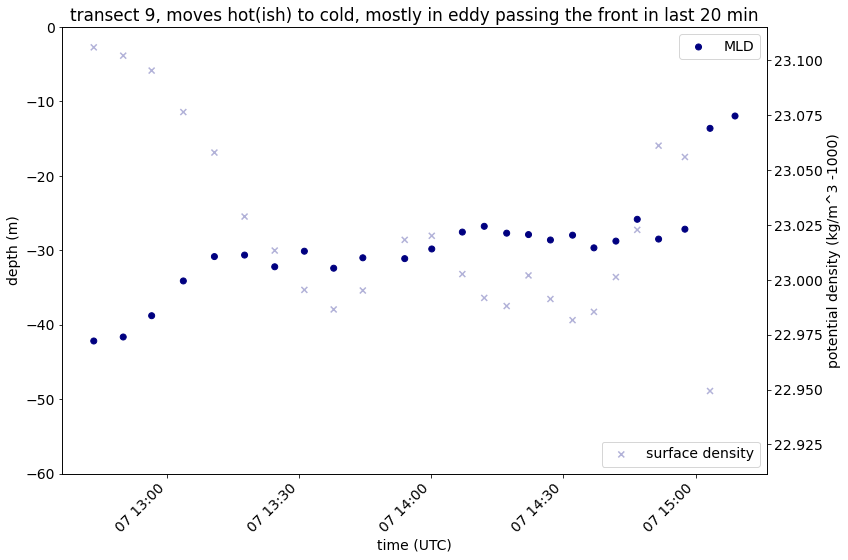

In [14]:
index_start = 94
index_end = 121
fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(dt_clean[index_start:index_end], mld_clean[index_start:index_end], cmap='jet', c = transect_clean[index_start:index_end], label='MLD')
ax2 = ax.twinx()
ax2.scatter(dt_clean[index_start:index_end], surface_density_clean[index_start:index_end], marker='x', c = transect_clean[index_start:index_end], cmap='jet', alpha=0.3,label='surface density')
fig.autofmt_xdate(rotation=45)
ax.set_ylim(-60, 0)
ax.set_title('transect 9, moves hot(ish) to cold, mostly in eddy passing the front in last 20 min')

ax.set_ylabel('depth (m)')
ax2.set_ylabel('potential density (kg/m^3 -1000)')
ax.set_xlabel('time (UTC)')
ax.legend()
ax2.legend(loc='lower right')
fig.tight_layout()
# fig.savefig('sept7_mld.png')

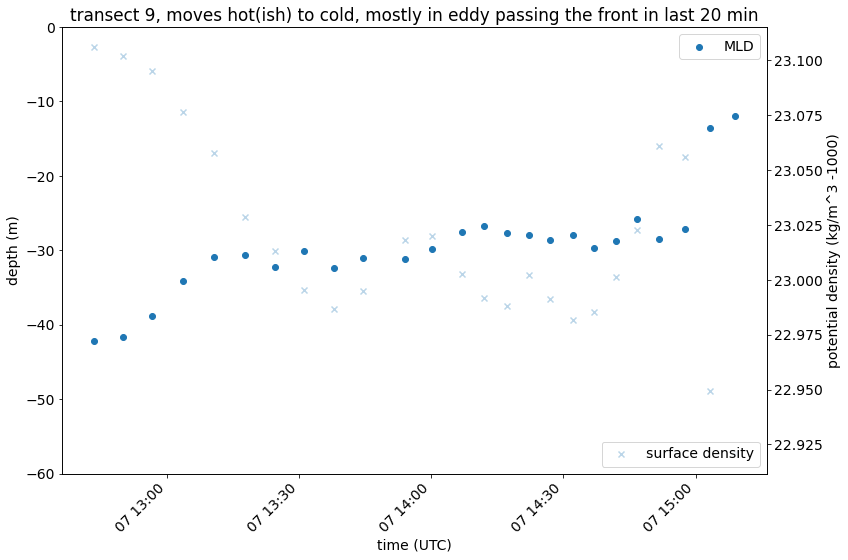

In [15]:
index_start = 94
index_end = 121
fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(dt_clean[index_start:index_end], mld_clean[index_start:index_end], label='MLD')
ax2 = ax.twinx()
ax2.scatter(dt_clean[index_start:index_end], surface_density_clean[index_start:index_end], marker='x', alpha=0.3, label='surface density')

fig.autofmt_xdate(rotation=45)
ax.set_ylim(-60, 0)
ax.set_title('transect 9, moves hot(ish) to cold, mostly in eddy passing the front in last 20 min')
ax.set_ylabel('depth (m)')
ax2.set_ylabel('potential density (kg/m^3 -1000)')
ax.set_xlabel('time (UTC)')
ax.legend()
ax2.legend(loc='lower right')
fig.tight_layout()

### Visualize all the profile data

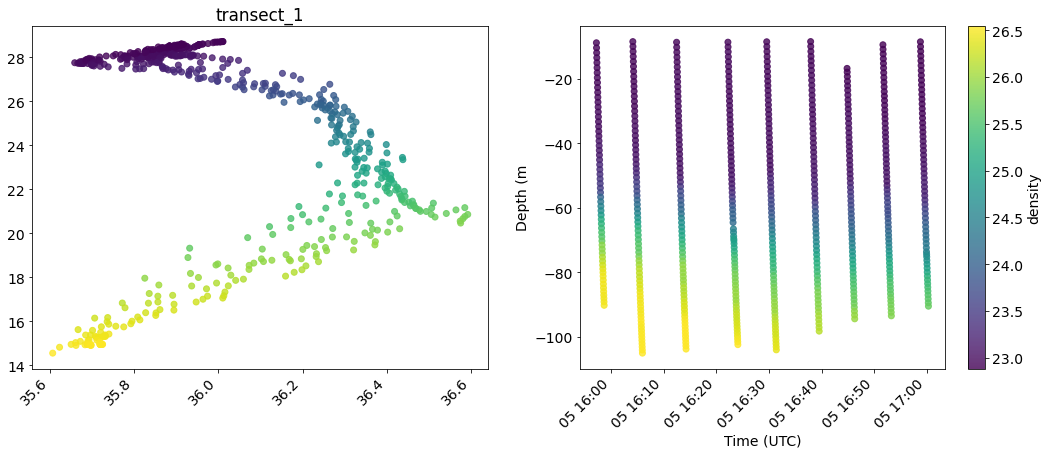

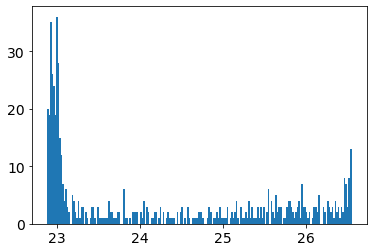

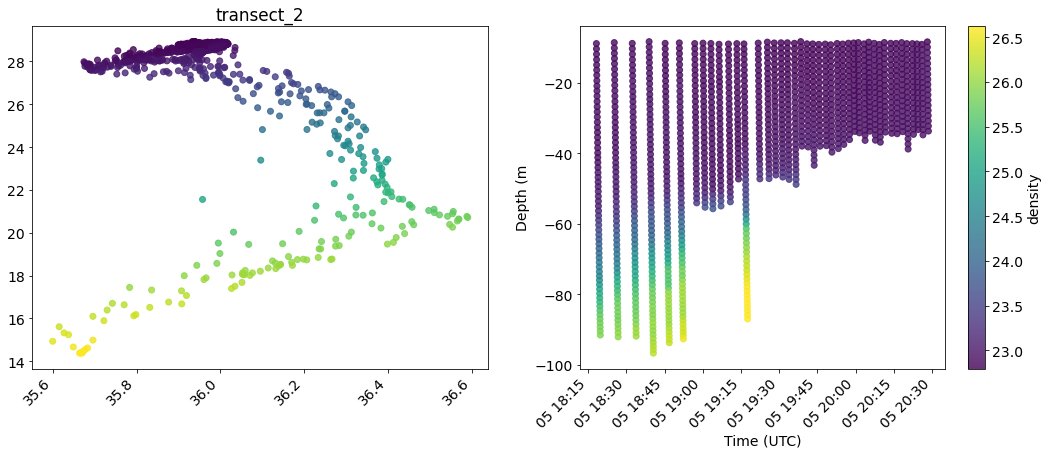

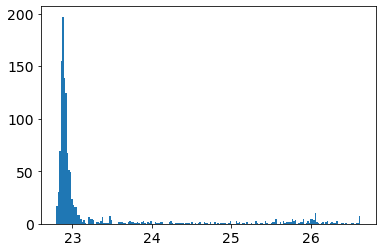

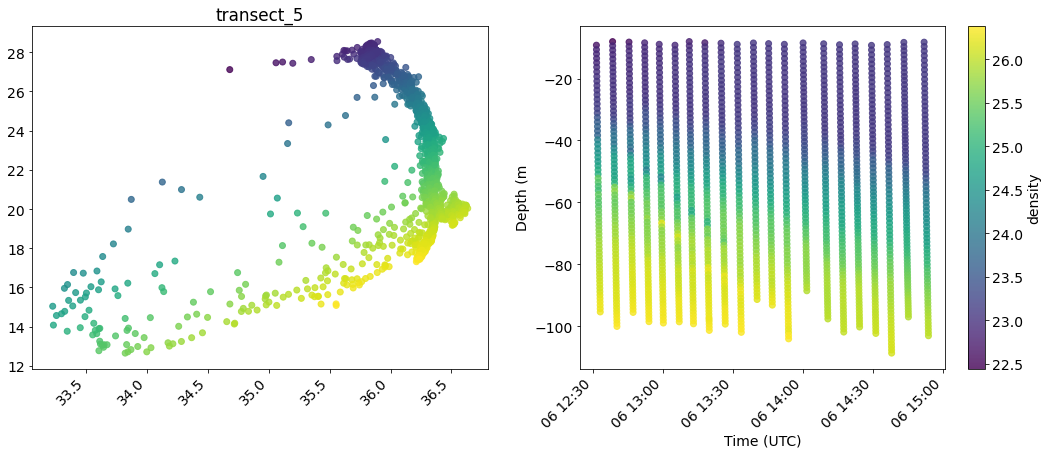

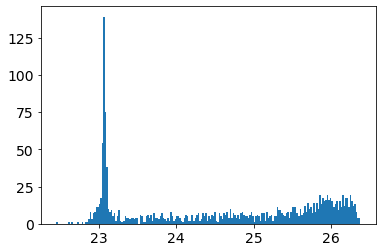

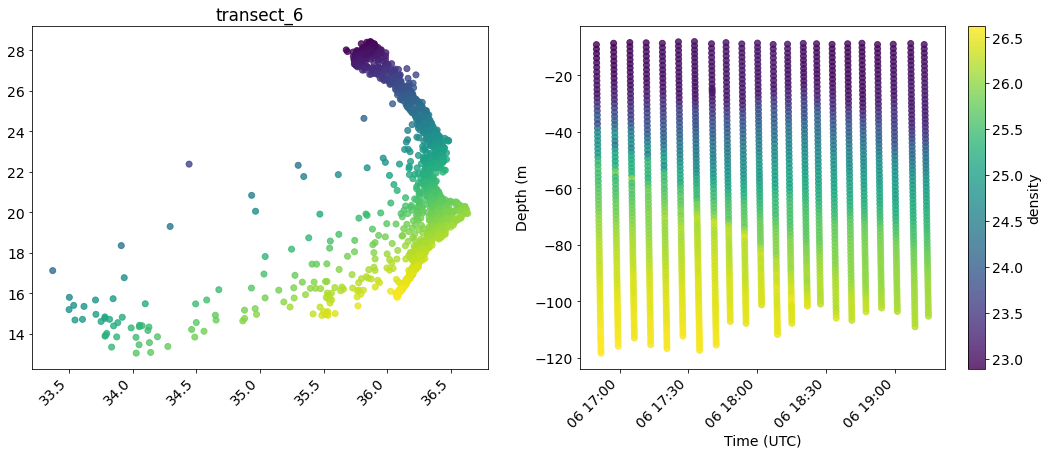

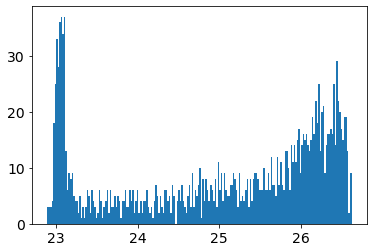

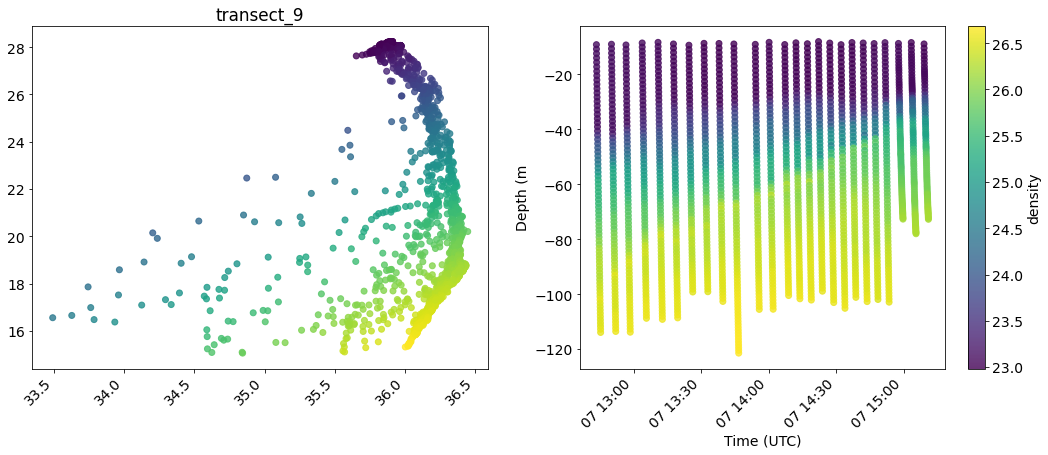

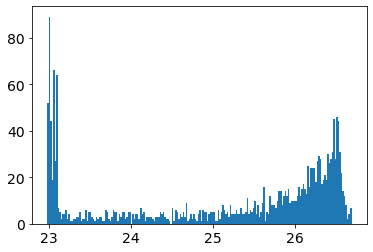

In [16]:
for i in np.unique(profiles.transect):
    df_subset = profiles[profiles.transect == i]
    df_subset = df_subset[df_subset['depth (dBars)'] < -8]
    
    fig, ax = plt.subplots(1,2, figsize=(18,7))
    ax[0].set_title(i)
    ax[0].scatter(df_subset['salinity (PSU)'], df_subset['temp (C)'], c=df_subset['potential density (kg/m^3 -1000)'], cmap='viridis', alpha=.8)

    sc = ax[1].scatter(df_subset['datetime'], df_subset['depth (dBars)'],c=df_subset['potential density (kg/m^3 -1000)'],cmap='viridis', alpha=0.8)
    cb = fig.colorbar(sc)
    cb.set_label('density')
    ax[1].set_ylabel('Depth (m')
    ax[1].set_xlabel('Time (UTC)')
#     ax[1].xaxis.set_major_locator(plt.MaxNLocator(7))
    fig.autofmt_xdate(rotation=45)
#     fig.savefig(i+'_chla.png')
    plt.show()
    
    plt.hist(df_subset['potential density (kg/m^3 -1000)'], bins=200)
    plt.show()

### Now visualize a bunch more data from the profiles

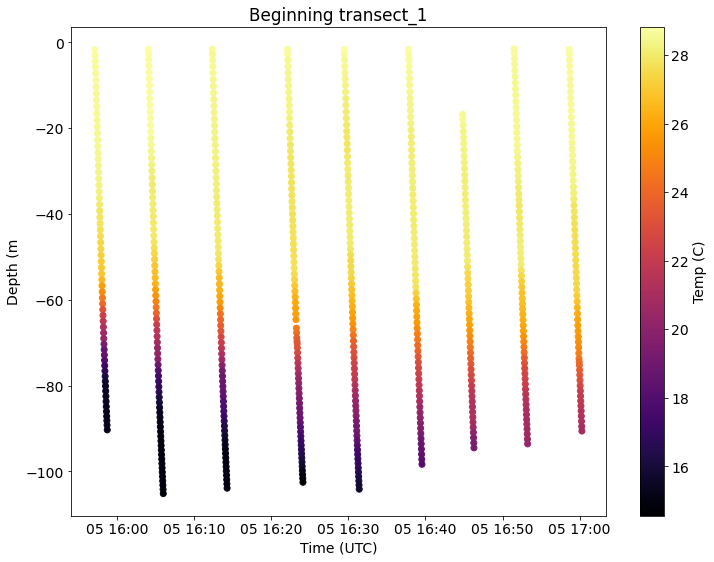

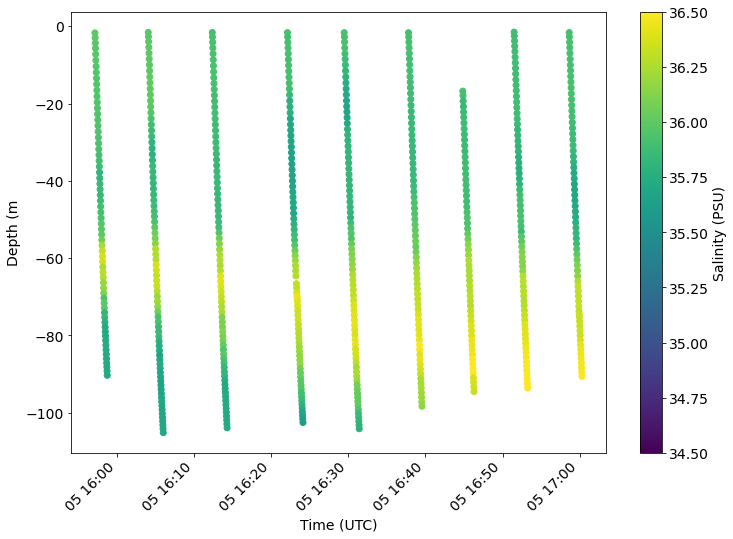

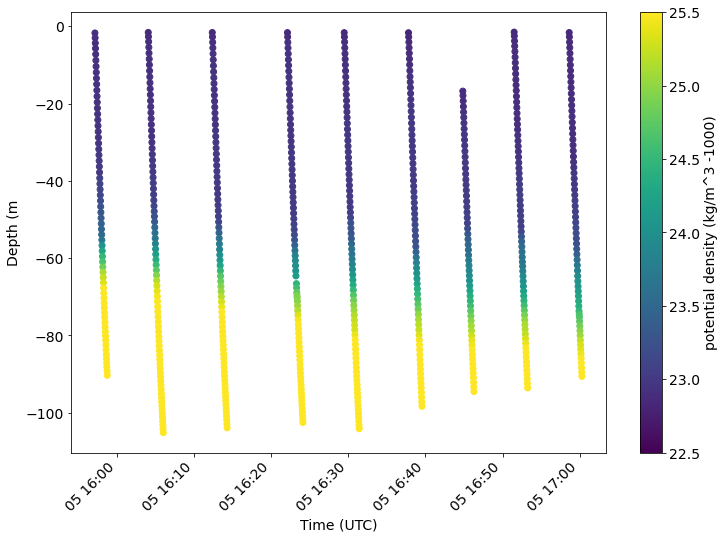

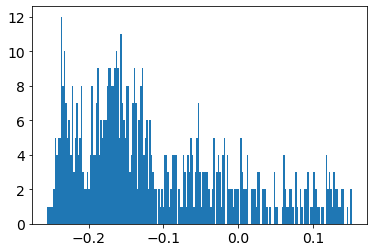

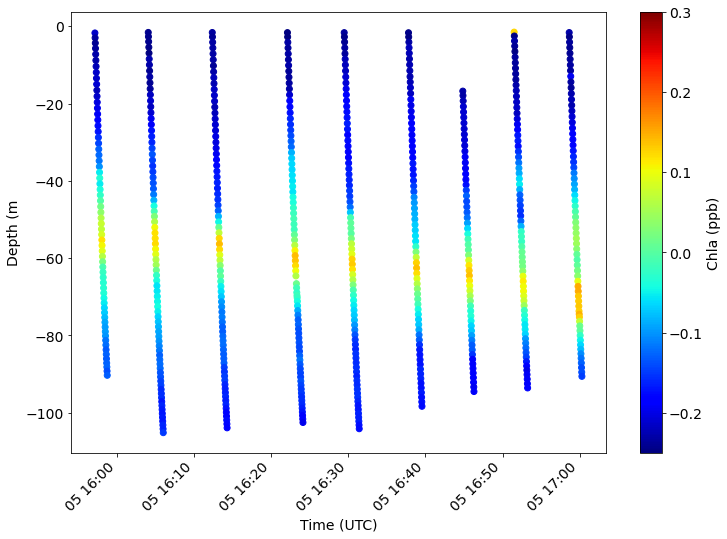

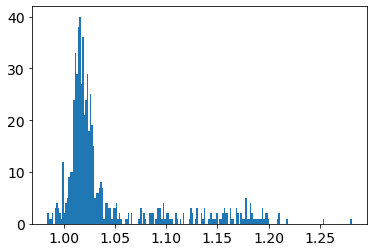

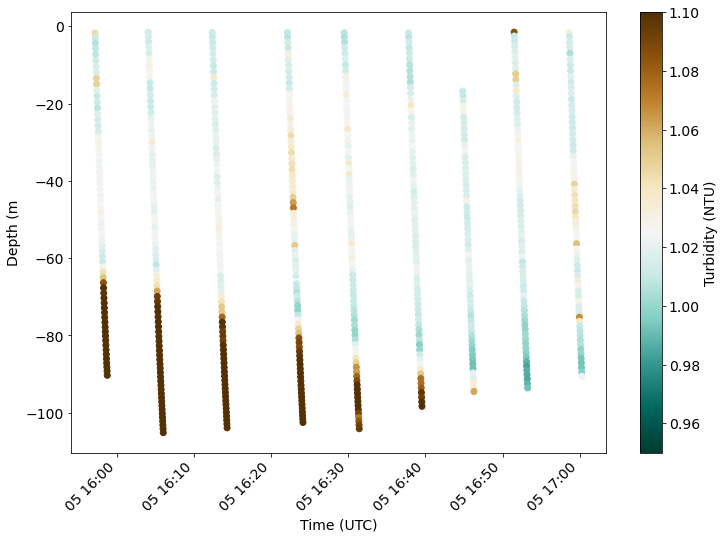

<ipython-input-16-3e1aa64a89fc>:67: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  sc = ax.scatter(df_subset['datetime'], df_subset['depth (dBars)'],c=df_subset['turb kinetic energy 1 (W/kg)'], cmap='jet',vmax=.001, norm=matplotlib.colors.LogNorm())


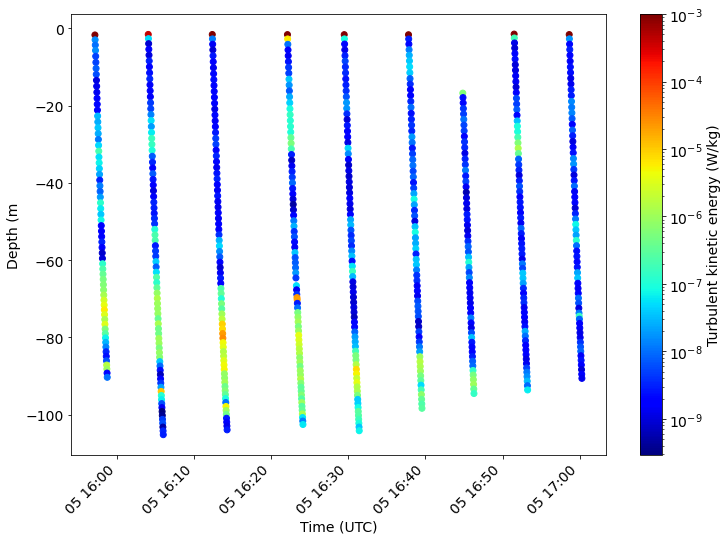

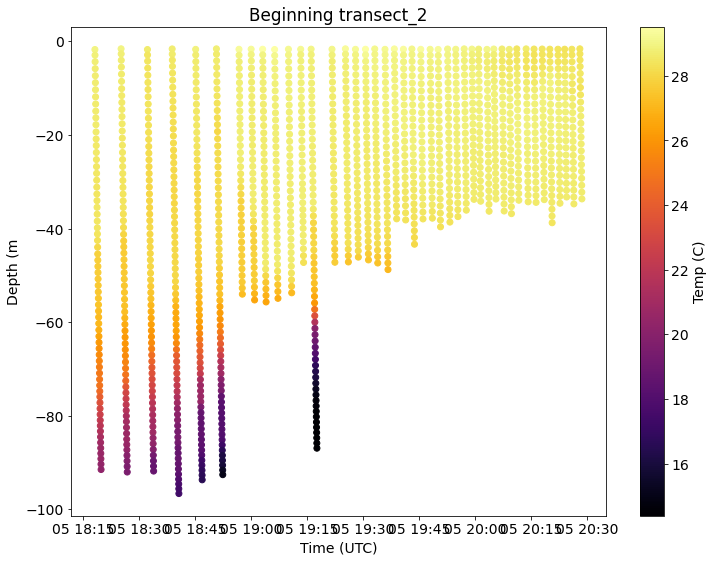

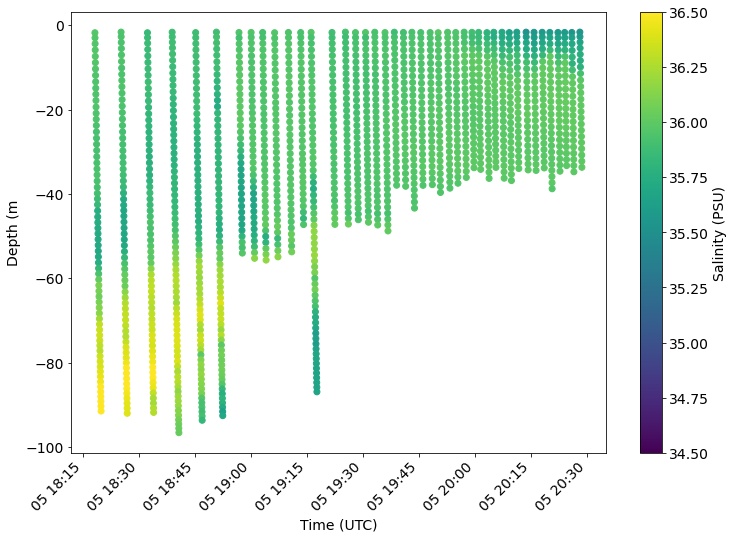

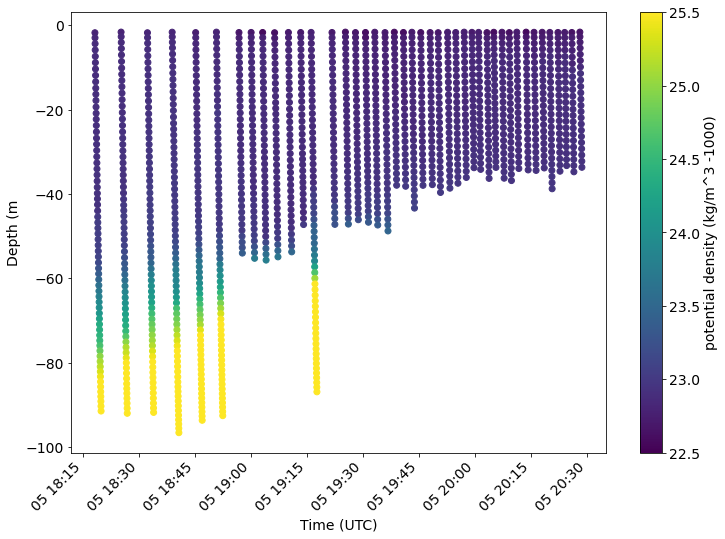

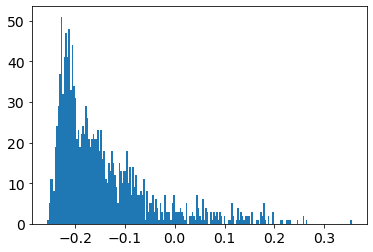

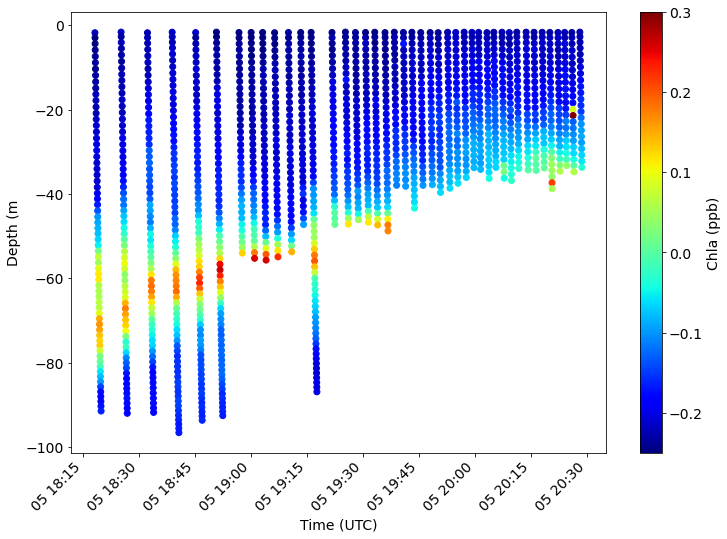

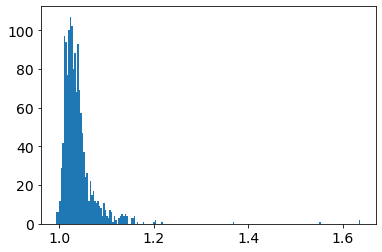

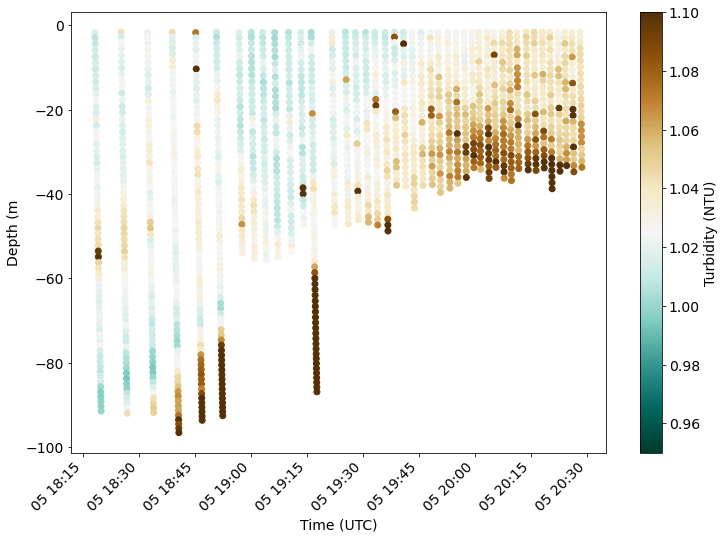

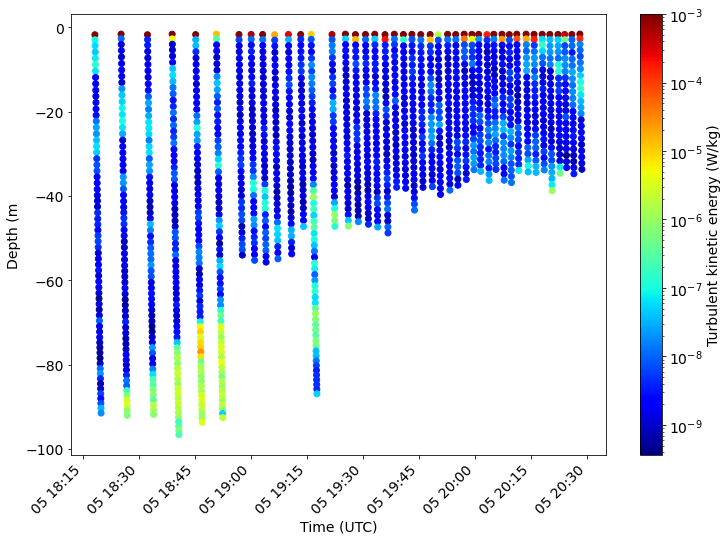

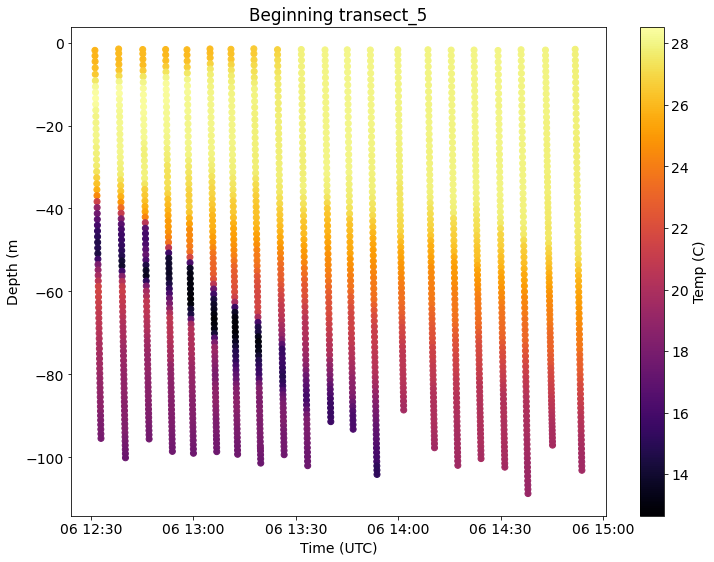

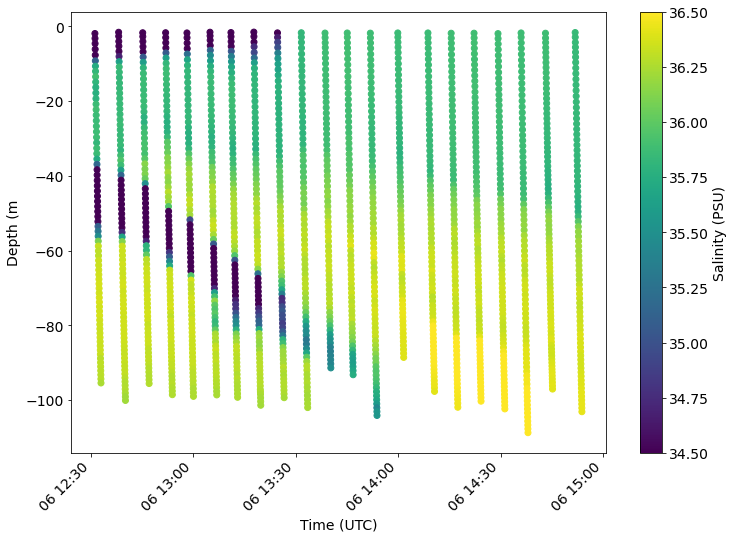

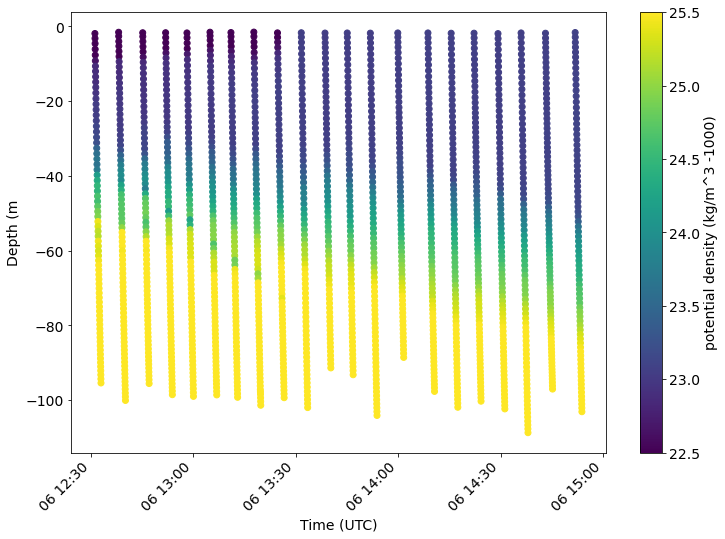

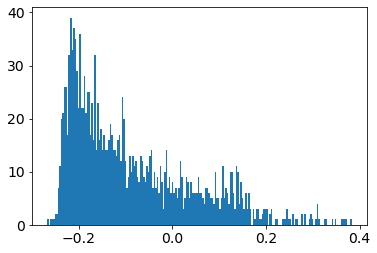

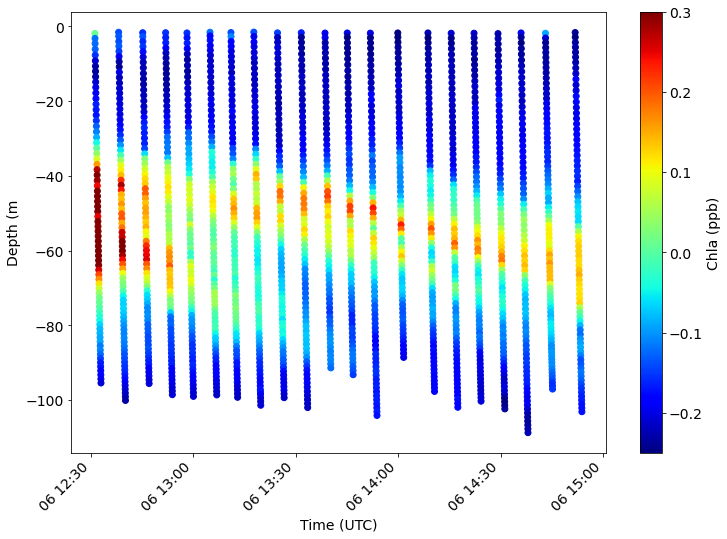

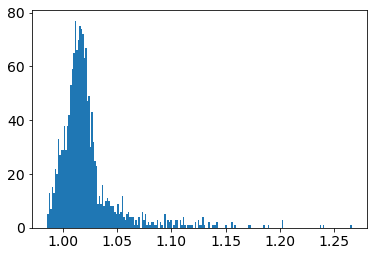

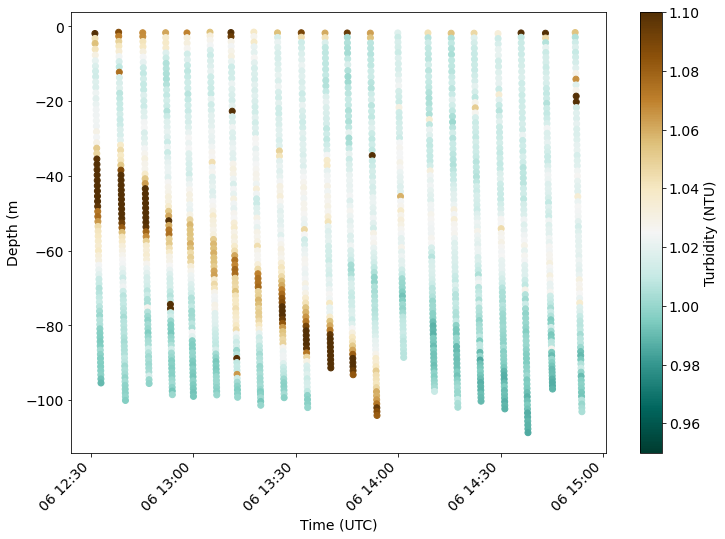

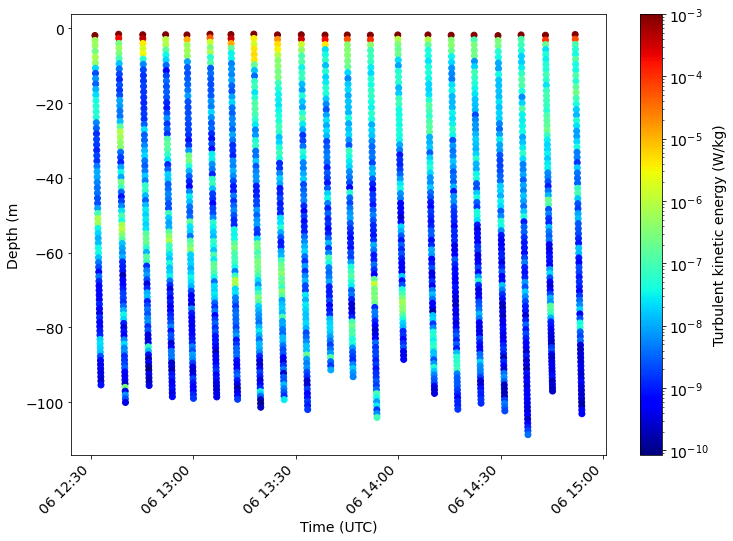

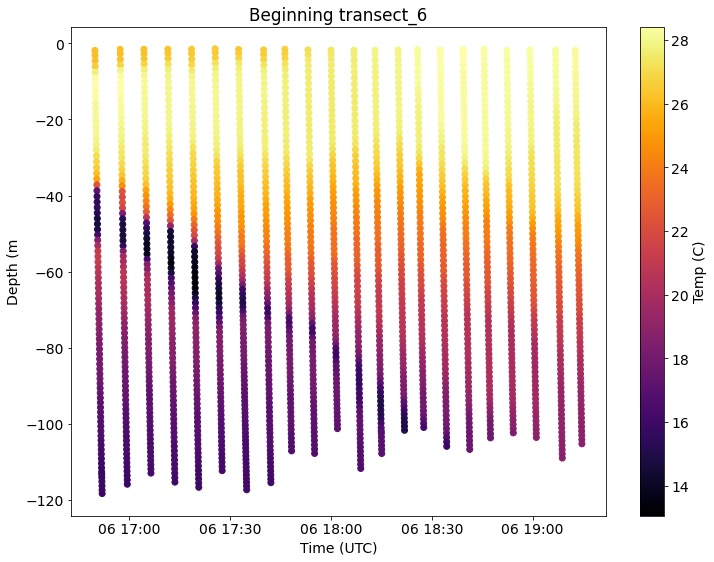

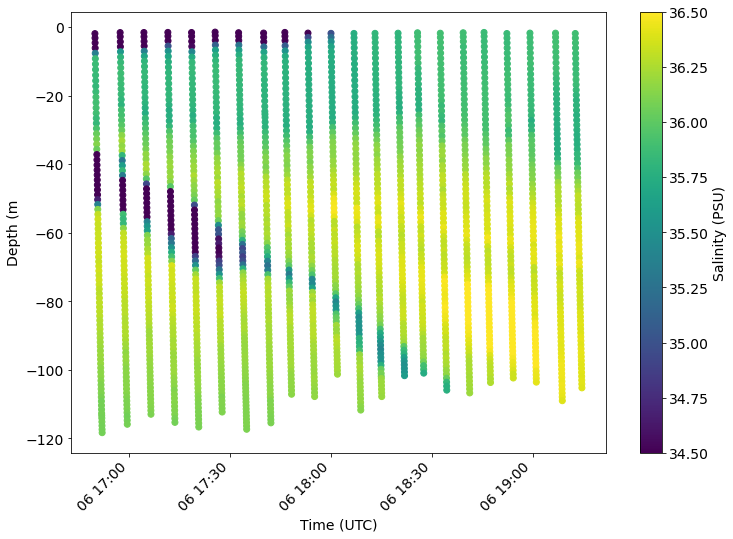

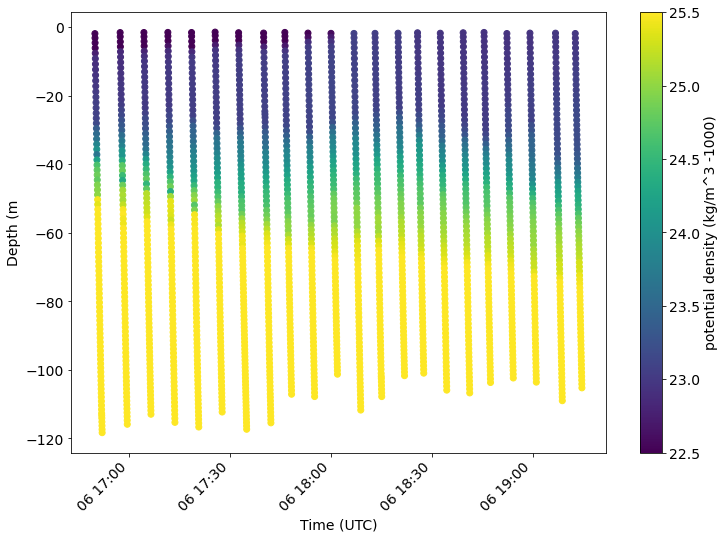

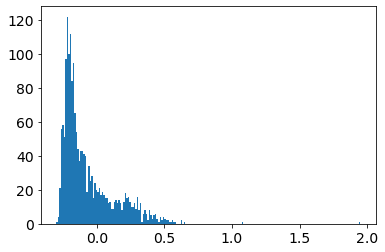

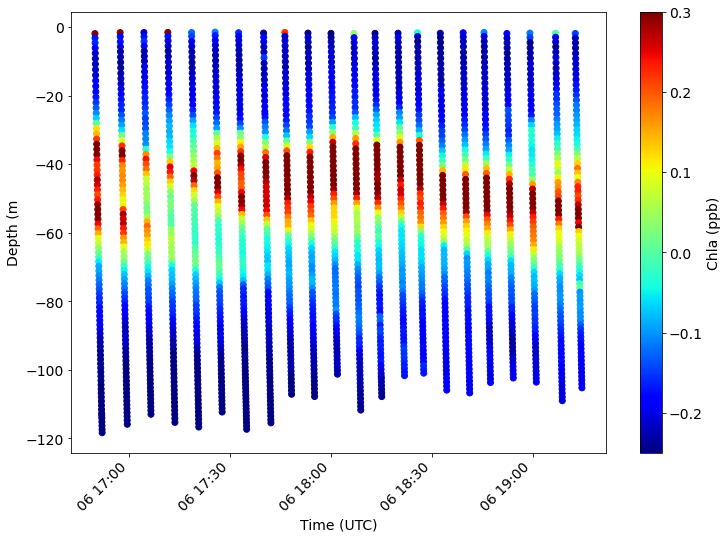

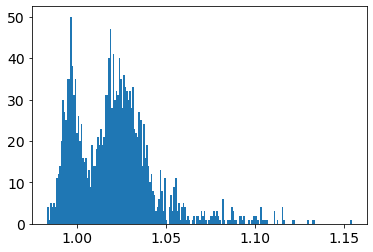

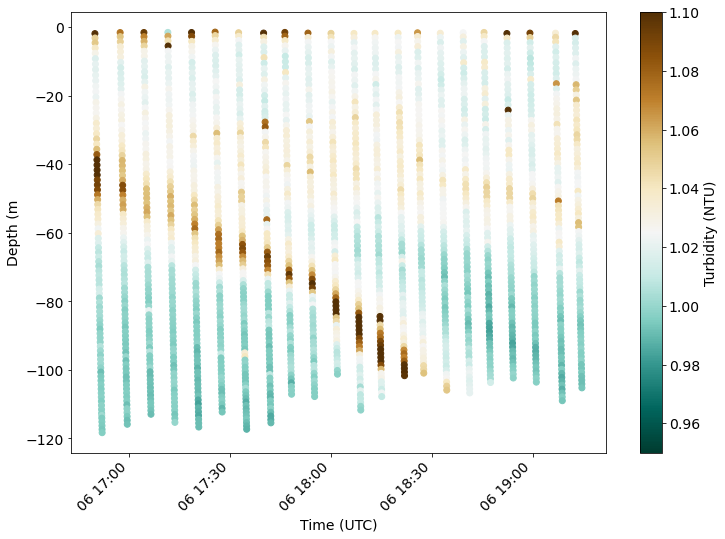

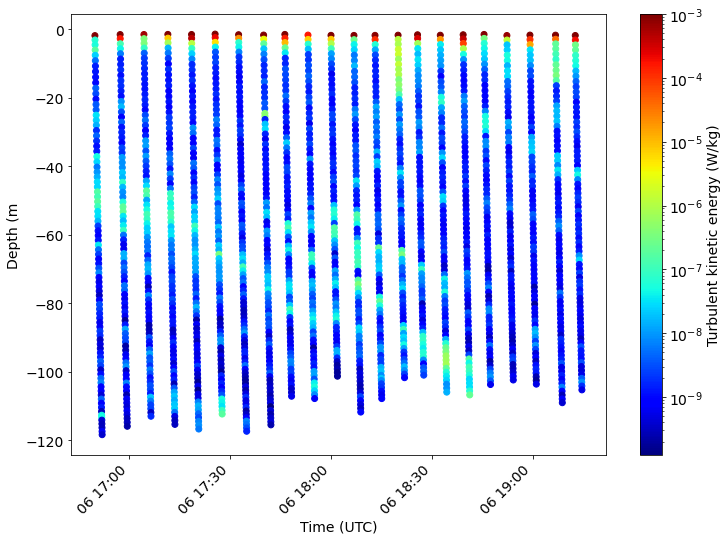

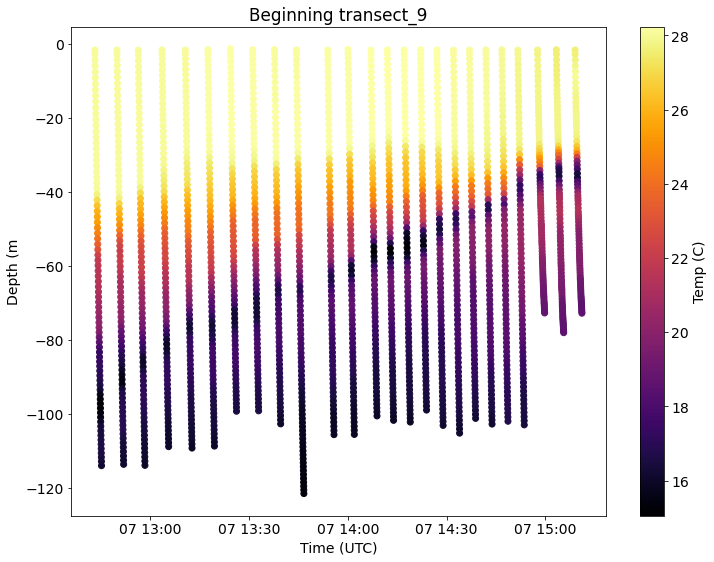

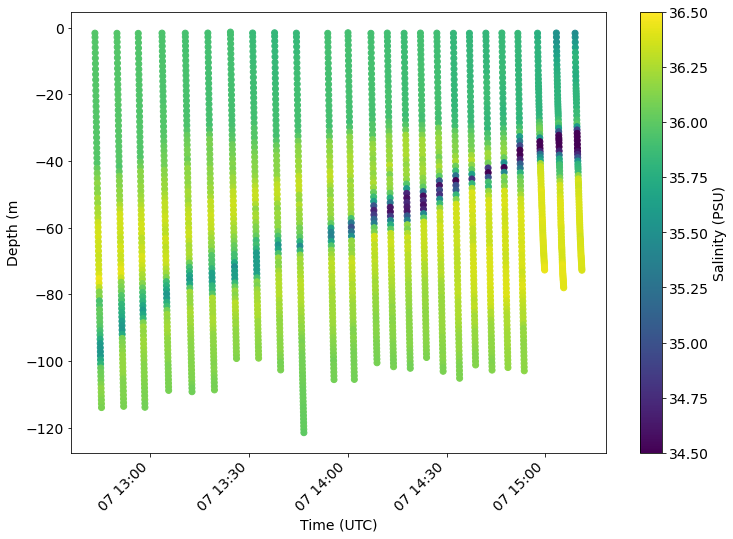

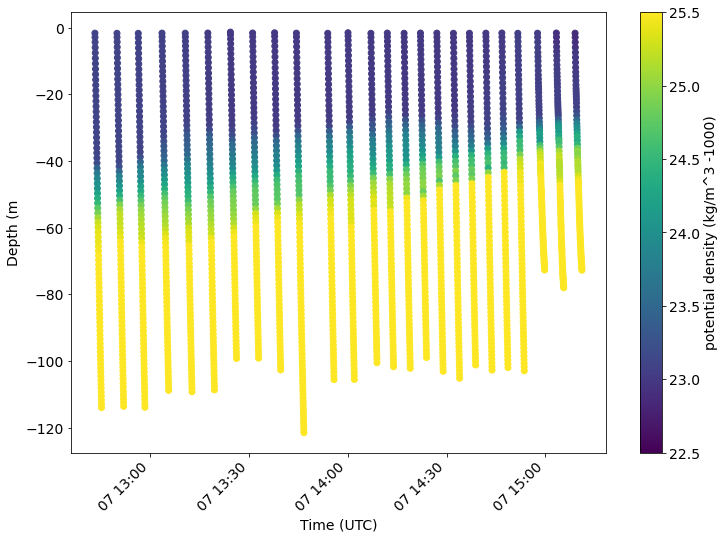

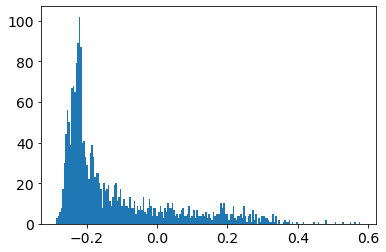

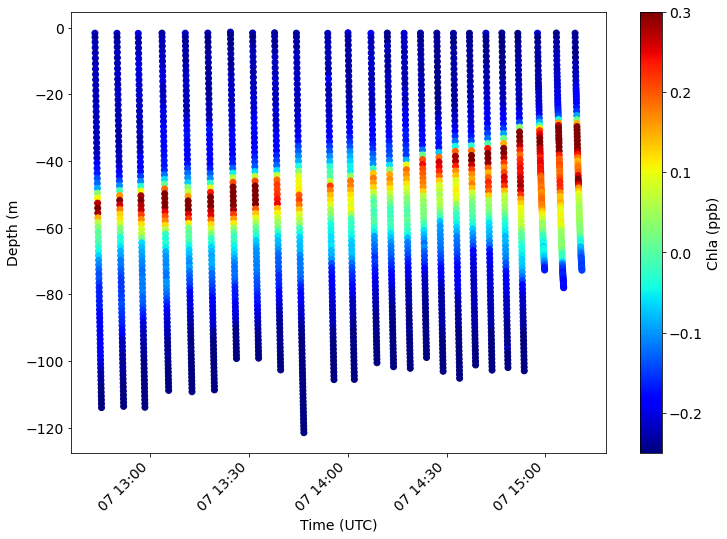

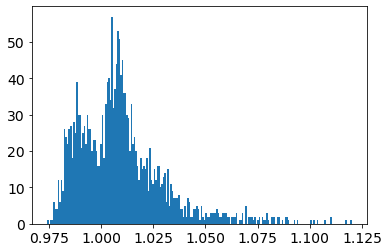

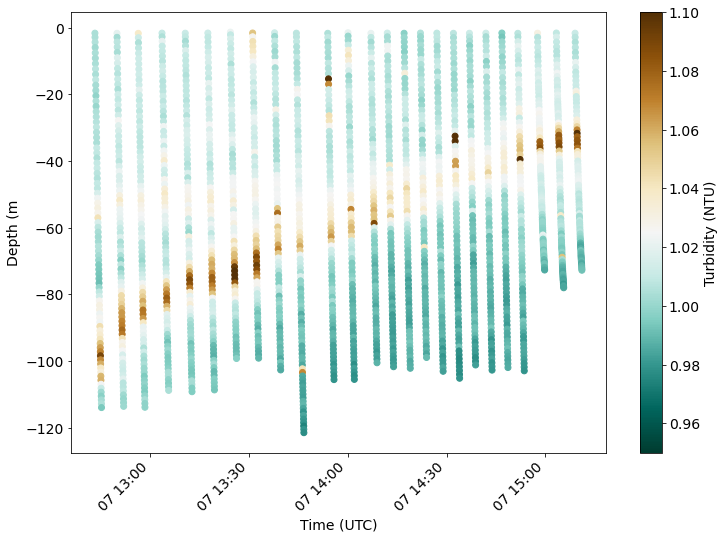

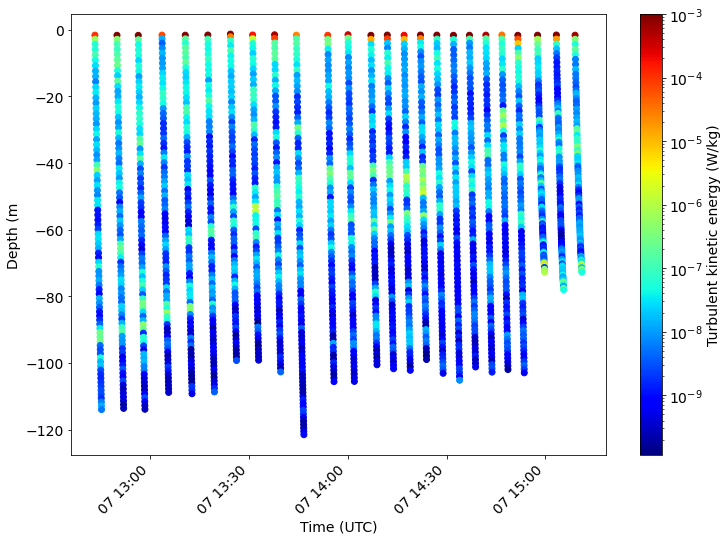

In [16]:
for i in np.unique(profiles.transect):
    df_subset = profiles[profiles.transect == i]
    
#     print('This is ' + i)
    
    fig, ax = plt.subplots(figsize=(12,9))
    sc = ax.scatter(df_subset['datetime'], df_subset['depth (dBars)'],c=df_subset['temp (C)'], cmap='inferno')
    cb = fig.colorbar(sc)
    cb.set_label('Temp (C)')
    ax.set_ylabel('Depth (m')
    ax.set_xlabel('Time (UTC)')
    ax.set_title('Beginning '+ i)
#     fig.savefig(i+'_temp.png')
    
    plt.show()
    
    fig, ax = plt.subplots(figsize=(12,9))
    sc = ax.scatter(df_subset['datetime'], df_subset['depth (dBars)'],c=df_subset['salinity (PSU)'], cmap='viridis', vmax= 36.5, vmin=34.5)
    cb = fig.colorbar(sc)
    cb.set_label('Salinity (PSU)')
    ax.set_ylabel('Depth (m')
    ax.set_xlabel('Time (UTC)')
    
    fig.autofmt_xdate(rotation=45)
#     fig.savefig(i+'_salinity.png')
    plt.show()
    
    fig, ax = plt.subplots(figsize=(12,9))
    sc = ax.scatter(df_subset['datetime'], df_subset['depth (dBars)'],c=df_subset['potential density (kg/m^3 -1000)'], vmin=22.5, vmax=25.5, cmap='viridis')
    cb = fig.colorbar(sc)
    cb.set_label('potential density (kg/m^3 -1000)')
    ax.set_ylabel('Depth (m')
    ax.set_xlabel('Time (UTC)')
    
    fig.autofmt_xdate(rotation=45)
#     fig.savefig(i+'_density.png')
    plt.show()
    
    plt.hist(df_subset['chla (ppb)'], bins=200)
    plt.show()
    
    import matplotlib
    fig, ax = plt.subplots(figsize=(12,9))
    sc = ax.scatter(df_subset['datetime'], df_subset['depth (dBars)'],c=df_subset['chla (ppb)'],vmax=0.3, cmap='jet', vmin=-0.25)
    cb = fig.colorbar(sc)
    cb.set_label('Chla (ppb)')
    ax.set_ylabel('Depth (m')
    ax.set_xlabel('Time (UTC)')
    fig.autofmt_xdate(rotation=45)
#     fig.savefig(i+'_chla.png')
    plt.show()
    
    plt.hist(df_subset['turbidity (FTU)'], bins=200)
    plt.show()
    
    fig, ax = plt.subplots(figsize=(12,9))
    sc = ax.scatter(df_subset['datetime'], df_subset['depth (dBars)'],c=df_subset['turbidity (FTU)'], cmap='BrBG_r', vmax=1.1, vmin=.95)
    cb = fig.colorbar(sc)
    cb.set_label('Turbidity (NTU)')
    ax.set_ylabel('Depth (m')
    ax.set_xlabel('Time (UTC)')
    fig.autofmt_xdate(rotation=45)
#     fig.savefig(i+'_turbidity.png')
    plt.show()
    
    fig, ax = plt.subplots(figsize=(12,9))
    sc = ax.scatter(df_subset['datetime'], df_subset['depth (dBars)'],c=df_subset['turb kinetic energy 1 (W/kg)'], cmap='jet',vmax=.001, norm=matplotlib.colors.LogNorm())
    cb = fig.colorbar(sc)
    cb.set_label('Turbulent kinetic energy (W/kg)')
    ax.set_ylabel('Depth (m')
    ax.set_xlabel('Time (UTC)')
    fig.autofmt_xdate(rotation=45)
#     fig.savefig(i+'_kineticenergy.png')
    plt.show()

In [17]:
df_subset = profiles[profiles.transect == 'transect_6']
df_subset

time  depth (dBars)   temp (C)  \
dt                                                                    
2021-09-06 16:49:43.314873600  249.701196      -1.867922  26.099560   
2021-09-06 16:49:44.814777600  249.701213      -3.146551  26.098362   
2021-09-06 16:49:46.314681600  249.701230      -4.562747  26.162236   
2021-09-06 16:49:47.814499200  249.701248      -6.080059  26.649378   
2021-09-06 16:49:49.314403200  249.701265      -7.602407  27.723572   
...                                   ...            ...        ...   
2021-09-06 19:14:31.666646400  249.801755    -100.726791  18.969128   
2021-09-06 19:14:33.166464000  249.801773    -101.873812  18.920975   
2021-09-06 19:14:34.666368000  249.801790    -102.996036  18.888520   
2021-09-06 19:14:36.166272000  249.801807    -104.111243  18.851696   
2021-09-06 19:14:37.666089600  249.801825    -105.232074  18.759960   

                               salinity (PSU)  \
dt                                              
2021-09-06 16:49:43.314873600       33.216592   
2021-09-06 16:49:44.814777600       33.234265   
2021-09-06 16:49:46.314681600       33.396588   
2021-09-06 16:49:47.814499200       34.157978   
2021-09-06 16:49:49.314403200       35.356552   
...                                       ...   
2021-09-06 19:14:31.666646400       36.408805   
2021-09-06 19:14:33.166464000       36.403962   
2021-09-06 19:14:34.666368000       36.411910   
2021-09-06 19:14:36.166272000       36.409689   
2021-09-06 19:14:37.666089600       36.405244   

                               potential density (kg/m^3 -1000)  chla (ppb)  \
dt                                                                            
2021-09-06 16:49:43.314873600                         21.659696    1.081461   
2021-09-06 16:49:44.814777600                         21.673474   -0.169075   
2021-09-06 16:49:46.314681600                         21.776047   -0.160567   
2021-09-06 16:49:47.814499200                         22.196532   -0.186019   
2021-09-06 16:49:49.314403200                         22.755055   -0.207435   
...                                                         ...         ...   
2021-09-06 19:14:31.666646400                         26.112195   -0.194670   
2021-09-06 19:14:33.166464000                         26.120893   -0.193341   
2021-09-06 19:14:34.666368000                         26.135342   -0.193317   
2021-09-06 19:14:36.166272000                         26.143113   -0.190062   
2021-09-06 19:14:37.666089600                         26.163182   -0.194932   

                               turbidity (FTU)  turb kinetic energy 1 (W/kg)  \
dt                                                                             
2021-09-06 16:49:43.314873600         1.104128                  6.342599e-03   
2021-09-06 16:49:44.814777600         1.049314                  6.659389e-08   
2021-09-06 16:49:46.314681600         1.052422                  5.581942e-08   
2021-09-06 16:49:47.814499200         1.038373                  1.741896e-07   
2021-09-06 16:49:49.314403200         1.028776                  2.308500e-08   
...                                        ...                           ...   
2021-09-06 19:14:31.666646400         0.994637                  5.398821e-10   
2021-09-06 19:14:33.166464000         0.991899                  3.947274e-09   
2021-09-06 19:14:34.666368000         0.991318                  8.811566e-09   
2021-09-06 19:14:36.166272000         0.991571                  1.812419e-09   
2021-09-06 19:14:37.666089600         0.993357                  5.248229e-10   

                               turb kinetic energy 2 (W/kg)    transect  \
dt                                                                        
2021-09-06 16:49:43.314873600                  4.722223e-04  transect_6   
2021-09-06 16:49:44.814777600                  1.088127e-07  transect_6   
2021-09-06 16:49:46.314681600                  3.726789e-08  transect_6   
2021-09-06 16:49:47.814499200  

### Interpolate the data to a grid.

This needs to be turned into a function and done for all the data.

In [96]:
import numpy as np
# from scipy.interpolate import interp2d
import scipy


data_variables = ['temp (C)', 'salinity (PSU)',
       'potential density (kg/m^3 -1000)', 'chla (ppb)', 'turbidity (FTU)',
       'turb kinetic energy 1 (W/kg)', 'turb kinetic energy 2 (W/kg)']

def interpolate_profiles(df, transect, plot=False):
    df_subset = df[df.transect == transect]
    interpolated_grids = []
    datetime_list = []
    for i in np.unique(df_subset.profile_num.values):
        datetime_list.append(df_subset[df_subset.profile_num == i].head(1).datetime.values)
    datetime_list = np.array(datetime_list)
    datetime_strings = np.datetime_as_string(datetime_list.flatten(), unit='m')
    
    # Original data (e.g. measurements)
    for data_var in data_variables:
        x_interp = np.arange(1,len(datetime_list), .5)
        y_interp = np.arange(-1,-115, -1)

        xx, yy = np.meshgrid(x_interp, y_interp)
        Z_table = df_subset[data_var].values

        Z = scipy.interpolate.griddata(np.array(list(zip(df_subset.profile_num.values , df_subset['depth (dBars)'].values ))), Z_table, (xx, yy), method='linear')

        datetime_list = []
        for i in np.unique(df_subset.profile_num.values):
            datetime_list.append(df_subset[df_subset.profile_num == i].head(1).datetime.values)
        datetime_list = np.array(datetime_list)
        datetime_strings = np.datetime_as_string(datetime_list.flatten(), unit='m')
        
        interpolated_grids.append(Z)

        if plot:
            fig, ax = plt.subplots(figsize=(12,7))
            im = ax.imshow(Z, aspect='auto', cmap='cividis')#vmax=22, vmin=26.4)

            cb = fig.colorbar(im)
            cb.set_label(data_var)

            ax.set(xticks=np.arange(0,np.max(df_subset.profile_num.values)*2-1,2), 
                   xticklabels=[x[6:].replace('T', ' ') for x in np.datetime_as_string(datetime_list.flatten(), unit='m')])

            ax.set_ylabel('Depth')
            ax.set_xlabel('Time (UTC)')
            fig.autofmt_xdate(rotation=30)
            ax.xaxis.set_major_locator(plt.MaxNLocator(15))

            # fig.savefig('transect6_profile_density.png')
            plt.show()
    return(datetime_list, interpolated_grids)

In [97]:
dates, interpolated_grids = interpolate_profiles(profiles, 'transect_5', plot=False)

In [27]:
plt.rcParams.update({'font.size': 14})

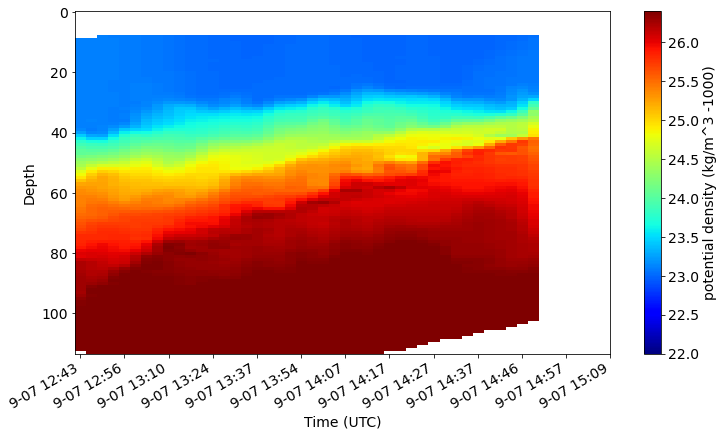

In [44]:
fig, ax = plt.subplots(figsize=(12,7))
im = ax.imshow(Z, aspect='auto', cmap='jet',vmax=22, vmin=26.4)

cb = fig.colorbar(im)
cb.set_label('potential density (kg/m^3 -1000)')

ax.set(xticks=np.arange(0,np.max(df_subset.profile_num.values)*2-1,2), 
       xticklabels=[x[6:].replace('T', ' ') for x in np.datetime_as_string(datetime_list.flatten(), unit='m')])

ax.set_ylabel('Depth')
ax.set_xlabel('Time (UTC)')
fig.autofmt_xdate(rotation=30)
ax.xaxis.set_major_locator(plt.MaxNLocator(15))

# fig.savefig('transect6_profile_density.png')

In [29]:
Z[:30].shape

(30, 42)

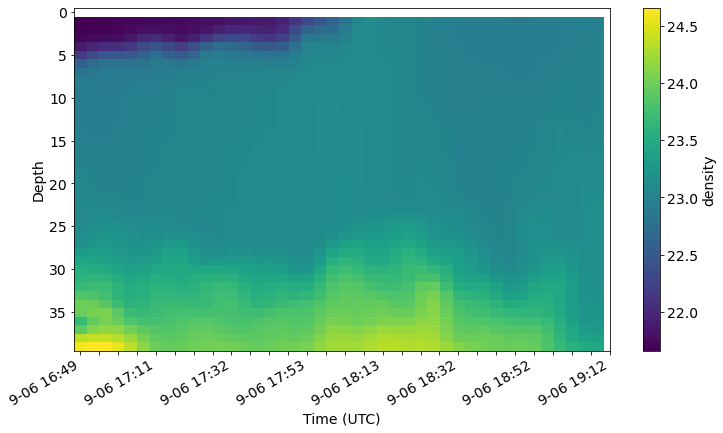

In [30]:
fig, ax = plt.subplots(figsize=(12,7))
im = ax.imshow(Z[:40], aspect='auto', cmap='viridis',)#vmax=0.45, vmin=-0.30)

cb = fig.colorbar(im)
cb.set_label('density')

ax.set(xticks=np.arange(0,np.max(df_subset.profile_num.values)*2-1,2), 
       xticklabels=[x[6:].replace('T', ' ') for x in np.datetime_as_string(datetime_list.flatten(), unit='m')])

ax.set_ylabel('Depth')
ax.set_xlabel('Time (UTC)')
fig.autofmt_xdate(rotation=30)
ax.xaxis.set_major_locator(plt.MaxNLocator(30))

# fig.savefig('transect6_profile_chla.png')

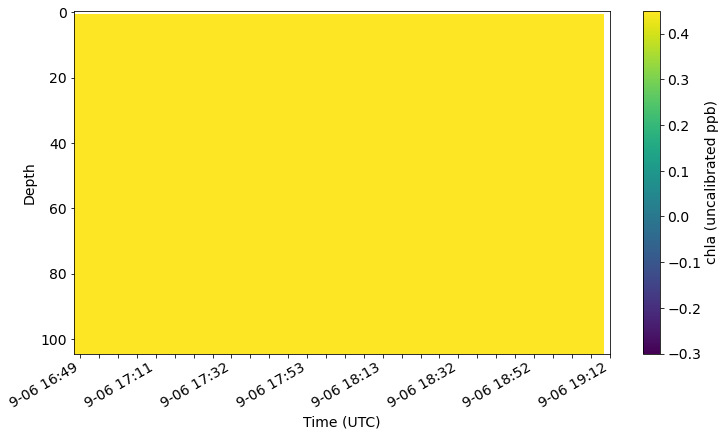

In [31]:
fig, ax = plt.subplots(figsize=(12,7))
im = ax.imshow(Z, aspect='auto', cmap='viridis',vmax=0.45, vmin=-0.30)

cb = fig.colorbar(im)
cb.set_label('chla (uncalibrated ppb)')

ax.set(xticks=np.arange(0,np.max(df_subset.profile_num.values)*2-1,2), 
       xticklabels=[x[6:].replace('T', ' ') for x in np.datetime_as_string(datetime_list.flatten(), unit='m')])

ax.set_ylabel('Depth')
ax.set_xlabel('Time (UTC)')
fig.autofmt_xdate(rotation=30)
ax.xaxis.set_major_locator(plt.MaxNLocator(30))

fig.savefig('transect6_profile_chla.png')

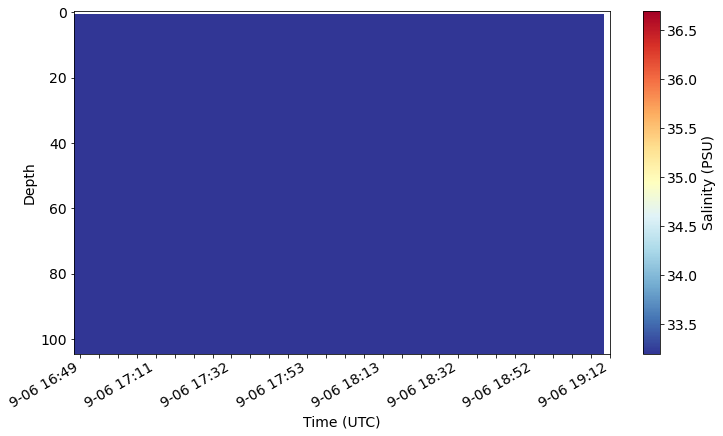

In [32]:
fig, ax = plt.subplots(figsize=(12,7))
im = ax.imshow(Z, aspect='auto', cmap='RdYlBu_r', vmin=33.2, vmax=36.7)

cb = fig.colorbar(im)
cb.set_label('Salinity (PSU)')

ax.set(xticks=np.arange(0,np.max(df_subset.profile_num.values)*2-1,2), 
       xticklabels=[x[6:].replace('T', ' ') for x in np.datetime_as_string(datetime_list.flatten(), unit='m')])

ax.set_ylabel('Depth')
ax.set_xlabel('Time (UTC)')
fig.autofmt_xdate(rotation=30)
ax.xaxis.set_major_locator(plt.MaxNLocator(30))


fig.savefig('transect6_profile_sal.png')

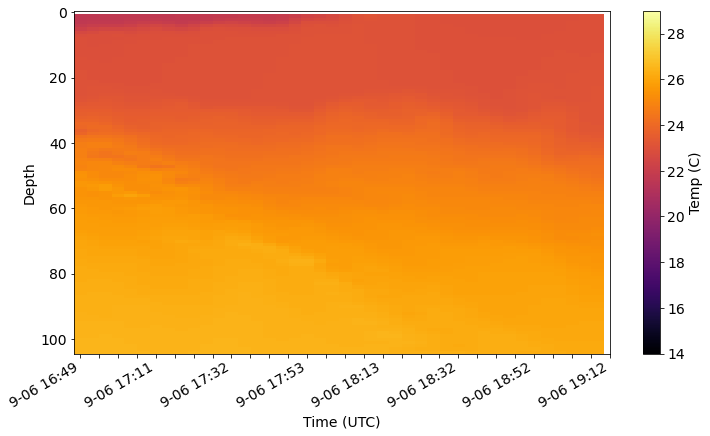

In [33]:
fig, ax = plt.subplots(figsize=(12,7))
im = ax.imshow(Z, aspect='auto', cmap='inferno', vmin=14, vmax=29)

cb = fig.colorbar(im)
cb.set_label('Temp (C)')

ax.set(xticks=np.arange(0,np.max(df_subset.profile_num.values)*2-1,2), 
       xticklabels=[x[6:].replace('T', ' ') for x in np.datetime_as_string(datetime_list.flatten(), unit='m')])

ax.set_ylabel('Depth')
ax.set_xlabel('Time (UTC)')
fig.autofmt_xdate(rotation=30)
ax.xaxis.set_major_locator(plt.MaxNLocator(30))


fig.savefig('transect6_profile_temp.png')